In [1]:
import numpy as np
import scipy
import librosa, librosa.display
print(librosa.__version__)
import matplotlib.pyplot as plt
%matplotlib widget
import matplotlib.style as ms
ms.use("seaborn-v0_8")  
#importing audio widget from IPython.display for audio playback
import IPython.display as Ipd

0.10.1


Load sound file

(2391807,)
54.236


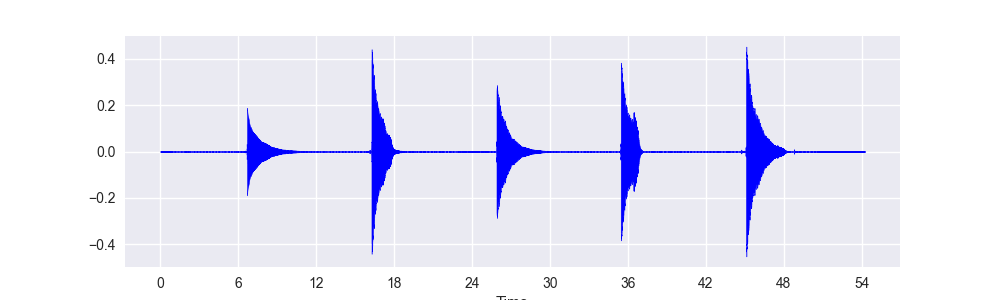

In [2]:
sr = 44100 # sampling rate
file = 'data/G4-circular-sound.wav'
signal, sr = librosa.load(file, sr=sr, mono=False)
print(signal.shape)
print('{:2.3f}'.format(librosa.samples_to_time(signal.shape[0], sr=sr)))
plt.figure(figsize=(10, 3))
librosa.display.waveshow(y=signal, sr=sr, color="blue")
Ipd.Audio(signal, rate=sr) # play audio

Load sensor data

[Text(0.5, 1.0, 'Gyroscope data')]

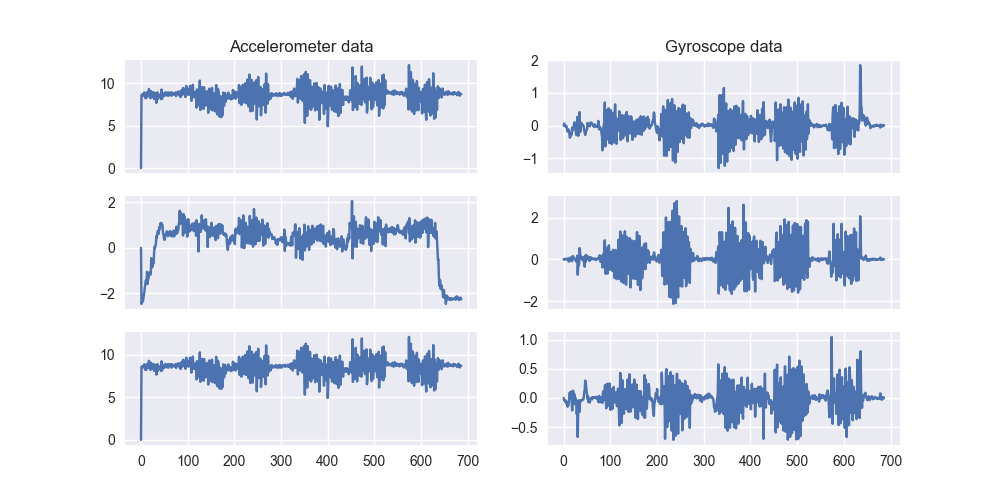

In [46]:
fig, ax = plt.subplots(3, 2, figsize=(10,5), sharex=True)

f = open("data/G4-circular-acc.hand.x.txt", "r")
acc_hand_x = f.read()
acc_hand_x = acc_hand_x.split(" ")
acc_hand_x = np.array([float(x) for x in acc_hand_x])
ax[0, 0].plot(acc_hand_x)

f = open("data/G4-circular-acc.hand.y.txt", "r")
acc_hand_y = f.read()
acc_hand_y = acc_hand_y.split(" ")
acc_hand_y = np.array([float(x) for x in acc_hand_y])
ax[1, 0].plot(acc_hand_y)

f = open("data/G4-circular-acc.hand.z.txt", "r")
acc_hand_z = f.read()
acc_hand_z = acc_hand_z.split(" ")
acc_hand_z = np.array([float(x) for x in acc_hand_z])
ax[2, 0].plot(acc_hand_z)

f = open("data/G4-circular-gyro.hand.x.txt", "r")
gyro_hand_x = f.read()
gyro_hand_x = gyro_hand_x.split(" ")
gyro_hand_x = np.array([float(x) for x in gyro_hand_x])
ax[0, 1].plot(gyro_hand_x)

f = open("data/G4-circular-gyro.hand.y.txt", "r")
gyro_hand_y = f.read()
gyro_hand_y = gyro_hand_y.split(" ")
gyro_hand_y = np.array([float(x) for x in gyro_hand_y])
ax[1, 1].plot(gyro_hand_y)

f = open("data/G4-circular-gyro.hand.z.txt", "r")
gyro_hand_z = f.read()
gyro_hand_z = gyro_hand_z.split(" ")
gyro_hand_z = np.array([float(x) for x in gyro_hand_z])
ax[2, 1].plot(gyro_hand_z)

ax[0, 0].set(title='Accelerometer data')
ax[0, 1].set(title='Gyroscope data')

Extract onsets

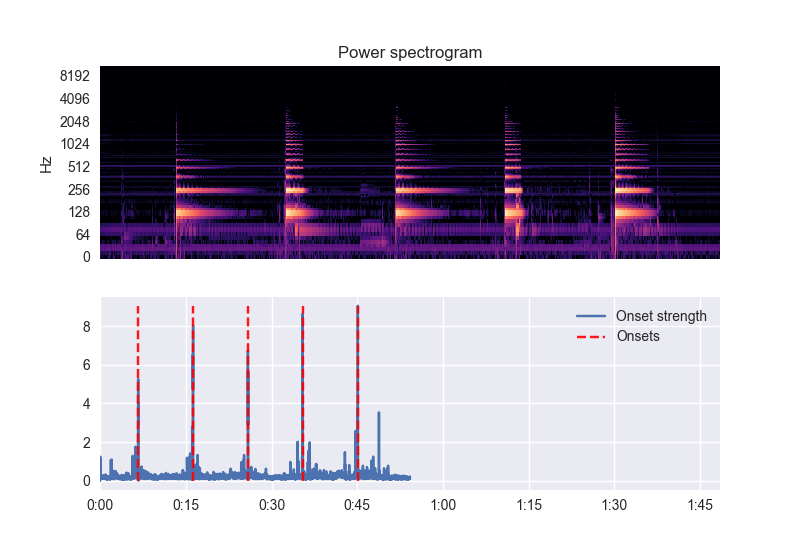

In [3]:
o_env = librosa.onset.onset_strength(y=signal, sr=sr)
times = librosa.times_like(o_env, sr=sr)
onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr, backtrack=True)
peaks = librosa.util.peak_pick(o_env, pre_max=500, post_max=500, 
                               pre_avg=500, post_avg=700, delta=0.5, wait=10)

D = np.abs(librosa.stft(signal))
fig, ax = plt.subplots(nrows=2, sharex=True)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), 
                         x_axis='time', y_axis='log', ax=ax[0])
ax[0].set(title='Power spectrogram')
ax[0].label_outer()
ax[1].plot(times, o_env, label='Onset strength')
ax[1].vlines(times[peaks], 0, o_env.max(), color='r', alpha=0.9, 
             linestyle='--', label='Onsets')
ax[1].legend()

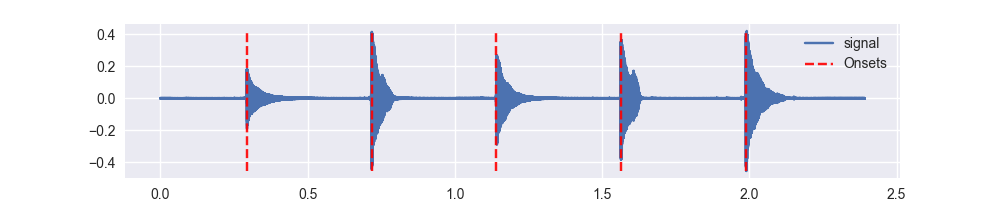

In [92]:
fig, ax = plt.subplots(figsize=(10,2))
ax.plot(signal, label='signal')
ax.vlines(librosa.frames_to_samples(peaks), signal.min(), signal.max(), 
           color='r', alpha=0.9, linestyle='--', label='Onsets')
ax.legend()

Backtrack onsets to detect attacks of the signals, otherwise the onsets start from the decay.

In [5]:
S = np.abs(librosa.stft(y=signal))
rms = librosa.feature.rms(S=S)
onset_bt_rms = librosa.onset.onset_backtrack(peaks, rms[0])

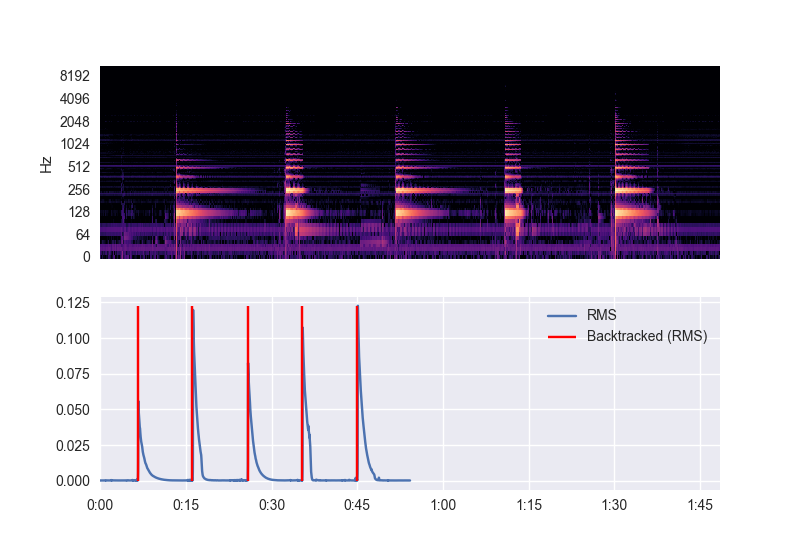

In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, sharex=True)
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[0])
ax[0].label_outer()
ax[1].plot(times, rms[0], label='RMS')
ax[1].vlines(times[onset_bt_rms], 0, rms.max(), label='Backtracked (RMS)', color='r')
ax[1].legend()

In [66]:
signal_duration = signal.shape[0] / sr
# interval at which a new sensor data is received
sensor_interval = signal_duration / acc_hand_x.shape[0]
sound2sensor = acc_hand_x.shape[0] / signal.shape[0]
sensor_peaks = librosa.frames_to_samples(onset_bt_rms) * sound2sensor

Text(0.5, 0.98, 'G4-vertical split')

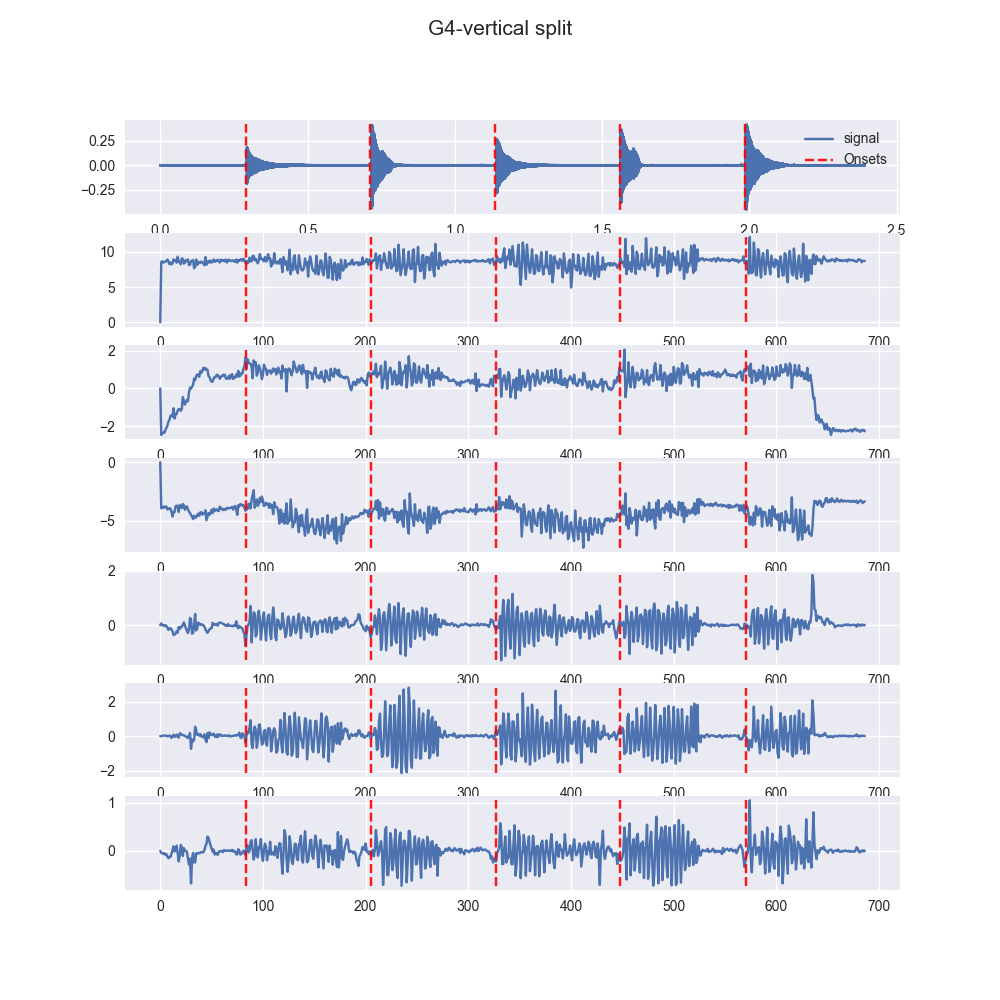

In [95]:
fig, ax = plt.subplots(nrows=7, figsize=(10,10))
ax[0].plot(signal, label='signal')
ax[0].vlines(librosa.frames_to_samples(onset_bt_rms), signal.min(), signal.max(), 
           color='r', alpha=0.9, linestyle='--', label='Onsets')
ax[0].legend()
ax[1].plot(acc_hand_x, label='accelerometer')
ax[1].vlines(sensor_peaks, acc_hand_x.min(), acc_hand_x.max(), 
           color='r', alpha=0.9, linestyle='--', label='Onsets')
ax[2].plot(acc_hand_y, label='accelerometer')
ax[2].vlines(sensor_peaks, acc_hand_y.min(), acc_hand_y.max(), 
           color='r', alpha=0.9, linestyle='--', label='Onsets')
ax[3].plot(acc_hand_z, label='accelerometer')
ax[3].vlines(sensor_peaks, acc_hand_z.min(), acc_hand_z.max(), 
           color='r', alpha=0.9, linestyle='--', label='Onsets')

ax[4].plot(gyro_hand_x, label='accelerometer')
ax[4].vlines(sensor_peaks, gyro_hand_x.min(), gyro_hand_x.max(), 
           color='r', alpha=0.9, linestyle='--', label='Onsets')
ax[5].plot(gyro_hand_y, label='accelerometer')
ax[5].vlines(sensor_peaks, gyro_hand_y.min(), gyro_hand_y.max(), 
           color='r', alpha=0.9, linestyle='--', label='Onsets')
ax[6].plot(gyro_hand_z, label='accelerometer')
ax[6].vlines(sensor_peaks, gyro_hand_z.min(), gyro_hand_z.max(), 
           color='r', alpha=0.9, linestyle='--', label='Onsets')
fig.suptitle('G4-vertical split', fontsize=15)

Split sound into segments

In [83]:
peak_samples = librosa.frames_to_samples(onset_bt_rms)
segments = []
previous_peak = 0
for peak in peak_samples:
    segment = signal[previous_peak:peak]
    segments.append(segment)
    previous_peak = peak
segments.append(signal[previous_peak:])
audio_segments = segments[1:]
#for segment in segments:
#    fig, ax = plt.subplots(figsize=(10,2))
#    ax.plot(segment)

Split sensor data into segments

In [81]:
sensor_peaks_int = [int(x) for x in sensor_peaks]
sensor_segments = []
previous_peak = 0
for peak in sensor_peaks_int:
    segment = acc_hand_x[previous_peak:peak]
    sensor_segments.append(segment)
    previous_peak = peak
sensor_segments.append(acc_hand_x[previous_peak:])
acc_hand_x_segments = sensor_segments[1:]
#for segment in sensor_segments:
#    fig, ax = plt.subplots(figsize=(10,2))
#    ax.plot(segment)

sensor_segments = []
previous_peak = 0
for peak in sensor_peaks_int:
    segment = acc_hand_y[previous_peak:peak]
    sensor_segments.append(segment)
    previous_peak = peak
sensor_segments.append(acc_hand_x[previous_peak:])
acc_hand_y_segments = sensor_segments[1:]

sensor_segments = []
previous_peak = 0
for peak in sensor_peaks_int:
    segment = acc_hand_z[previous_peak:peak]
    sensor_segments.append(segment)
    previous_peak = peak
sensor_segments.append(acc_hand_x[previous_peak:])
acc_hand_z_segments = sensor_segments[1:]

sensor_segments = []
previous_peak = 0
for peak in sensor_peaks_int:
    segment = gyro_hand_x[previous_peak:peak]
    sensor_segments.append(segment)
    previous_peak = peak
sensor_segments.append(acc_hand_x[previous_peak:])
gyro_hand_x_segments = sensor_segments[1:]

sensor_segments = []
previous_peak = 0
for peak in sensor_peaks_int:
    segment = gyro_hand_y[previous_peak:peak]
    sensor_segments.append(segment)
    previous_peak = peak
sensor_segments.append(acc_hand_x[previous_peak:])
gyro_hand_y_segments = sensor_segments[1:]

sensor_segments = []
previous_peak = 0
for peak in sensor_peaks_int:
    segment = gyro_hand_z[previous_peak:peak]
    sensor_segments.append(segment)
    previous_peak = peak
sensor_segments.append(acc_hand_x[previous_peak:])
gyro_hand_z_segments = sensor_segments[1:]

Save split data into a dataset

In [90]:
import os 
import scipy.io.wavfile as wavf

save_path = 'data-processed/G4-circular-sound'
if not os.path.exists(save_path):
    os.mkdir(save_path)

for i in range(len(audio_segments)):
    out_f = f'G4-circular-sound-{i}.wav'
    filepath = os.path.join(save_path, out_f)
    wavf.write(filepath, sr, audio_segments[i])

    sensor_filename = f'G4-circular-sensors-{i}.npy'
    filepath = os.path.join(save_path, sensor_filename)
    sensor_data = []
    sensor_data.append(acc_hand_x_segments[i])
    sensor_data.append(acc_hand_y_segments[i])
    sensor_data.append(acc_hand_z_segments[i])
    sensor_data.append(gyro_hand_x_segments[i])
    sensor_data.append(gyro_hand_y_segments[i])
    sensor_data.append(gyro_hand_z_segments[i])
    sensor_data = np.array(sensor_data)
    np.save(filepath, sensor_data)
